Text(0, 0.5, 'Best Fitness (Latency + Throughput)')

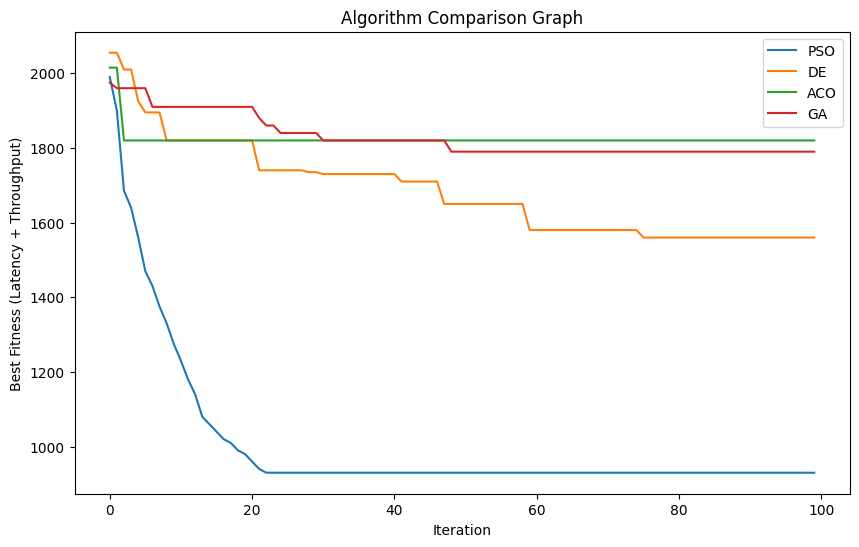

: 

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Shared functions and setup
num_tasks = 100  # Number of tasks (vehicles)
num_options = 4  # Task allocation choices: Local, RSU, MBS, Cloud
task_sizes = np.random.uniform(0.5, 5, num_tasks)  # Random task sizes
task_latencies = np.random.uniform(10, 100, num_tasks)

def calculate_distance(coord1, coord2):
    return np.sqrt((coord1[0] - coord2[0]) ** 2 + (coord1[1] - coord2[1]) ** 2)

# Task fitness: based on latency and throughput
def compute_latency(position):
    total_latency = 0
    for i, allocation in enumerate(position):
        if allocation == 0:
            total_latency += 10  # Local latency
        elif allocation == 1:
            total_latency += 30  # RSU
        elif allocation == 2:
            total_latency += 50  # MBS
        elif allocation == 3:
            total_latency += 100  # Cloud
    return total_latency

def compute_throughput(position):
    total_throughput = 0
    for i, allocation in enumerate(position):
        task_size = task_sizes[i]
        if allocation == 0:
            total_throughput += task_size / 10
        elif allocation == 1:
            total_throughput += task_size / 30
        elif allocation == 2:
            total_throughput += task_size / 50
        elif allocation == 3:
            total_throughput += task_size / 100
    return total_throughput

def fitness_function(position, w1=0.5, w2=0.5):
    latency = compute_latency(position)
    throughput = compute_throughput(position)
    return w1 * latency + w2 * (1 / throughput)

# PSO Algorithm
def run_pso(num_particles, w1, w2, num_iterations):
    particles_position = np.random.randint(0, num_options, size=(num_particles, num_tasks))
    particles_velocity = np.random.uniform(-1, 1, (num_particles, num_tasks))
    personal_best_position = np.copy(particles_position)
    personal_best_fitness = np.inf * np.ones(num_particles)
    global_best_position = None
    global_best_fitness = np.inf
    
    best_fitness_per_iteration = []

    for iteration in range(num_iterations):
        for i in range(num_particles):
            current_fitness = fitness_function(particles_position[i], w1, w2)
            if current_fitness < personal_best_fitness[i]:
                personal_best_fitness[i] = current_fitness
                personal_best_position[i] = np.copy(particles_position[i])
            if current_fitness < global_best_fitness:
                global_best_fitness = current_fitness
                global_best_position = np.copy(particles_position[i])
        
        best_fitness_per_iteration.append(global_best_fitness)

        for i in range(num_particles):
            r1, r2 = np.random.rand(num_tasks), np.random.rand(num_tasks)
            particles_velocity[i] = (0.5 * particles_velocity[i] +
                                     1.5 * r1 * (personal_best_position[i] - particles_position[i]) +
                                     1.5 * r2 * (global_best_position - particles_position[i]))
            particles_position[i] = np.clip(np.round(particles_position[i] + particles_velocity[i]), 0, num_options - 1).astype(int)

    return global_best_position, global_best_fitness, best_fitness_per_iteration

# Differential Evolution Algorithm
def run_de(num_population, num_iterations, F=0.8, CR=0.9):
    population = np.random.randint(0, num_options, size=(num_population, num_tasks))
    best_fitness_per_iteration = []
    best_global_fitness = np.inf
    best_global_position = None

    for iteration in range(num_iterations):
        for i in range(num_population):
            indices = [idx for idx in range(num_population) if idx != i]
            a, b, c = population[random.sample(indices, 3)]
            mutant = np.clip(np.round(a + F * (b - c)), 0, num_options - 1).astype(int)

            trial = np.copy(population[i])
            for j in range(num_tasks):
                if np.random.rand() < CR:
                    trial[j] = mutant[j]

            if fitness_function(trial) < fitness_function(population[i]):
                population[i] = trial

        # Track the best global fitness
        best_individual_fitness = np.inf
        best_individual_position = None
        for individual in population:
            fitness = fitness_function(individual)
            if fitness < best_individual_fitness:
                best_individual_fitness = fitness
                best_individual_position = individual

        if best_individual_fitness < best_global_fitness:
            best_global_fitness = best_individual_fitness
            best_global_position = best_individual_position

        best_fitness_per_iteration.append(best_global_fitness)

    return best_global_position, best_global_fitness, best_fitness_per_iteration

# Ant Colony Optimization (ACO)
def run_aco(num_ants, num_iterations, alpha=1, beta=1, evaporation_rate=0.5):
    pheromone = np.ones((num_tasks, num_options))
    best_fitness_per_iteration = []
    best_global_fitness = np.inf
    best_global_position = None

    for iteration in range(num_iterations):
        ants_positions = np.zeros((num_ants, num_tasks), dtype=int)
        for ant in range(num_ants):
            for task in range(num_tasks):
                # Use the i-th task's latency
                probabilities = (pheromone[task] ** alpha) * (1 / (task_latencies[task] ** beta))
                probabilities /= probabilities.sum()
                ants_positions[ant, task] = np.random.choice(np.arange(num_options), p=probabilities)

        # Evaluate ants
        for ant in ants_positions:
            fitness = fitness_function(ant)
            if fitness < best_global_fitness:
                best_global_fitness = fitness
                best_global_position = ant

        # Update pheromones
        pheromone *= (1 - evaporation_rate)
        for ant in ants_positions:
            for task, option in enumerate(ant):
                pheromone[task, option] += 1 / best_global_fitness

        best_fitness_per_iteration.append(best_global_fitness)

    return best_global_position, best_global_fitness, best_fitness_per_iteration

# Genetic Algorithm (GA)
def run_ga(num_population, num_iterations, mutation_rate=0.1):
    population = np.random.randint(0, num_options, size=(num_population, num_tasks))
    best_fitness_per_iteration = []
    best_global_fitness = np.inf
    best_global_position = None

    for iteration in range(num_iterations):
        fitness_scores = np.array([fitness_function(individual) for individual in population])
        probabilities = 1 / (1 + fitness_scores)  # Inverse fitness to maximize selection probability
        probabilities /= probabilities.sum()

        new_population = []
        for _ in range(num_population // 2):
            parents = population[np.random.choice(np.arange(num_population), size=2, p=probabilities)]
            crossover_point = np.random.randint(1, num_tasks - 1)
            offspring1 = np.concatenate([parents[0][:crossover_point], parents[1][crossover_point:]])
            offspring2 = np.concatenate([parents[1][:crossover_point], parents[0][crossover_point:]])

            new_population.append(offspring1)
            new_population.append(offspring2)

        # Apply mutation
        new_population = np.array(new_population)
        mutations = np.random.rand(num_population, num_tasks) < mutation_rate
        new_population[mutations] = np.random.randint(0, num_options, size=np.sum(mutations))

        population = new_population

        # Evaluate best fitness
        for individual in population:
            fitness = fitness_function(individual)
            if fitness < best_global_fitness:
                best_global_fitness = fitness
                best_global_position = individual

        best_fitness_per_iteration.append(best_global_fitness)

    return best_global_position, best_global_fitness, best_fitness_per_iteration

# Main execution
num_particles = 50
num_iterations = 100

# PSO
_, _, pso_fitness = run_pso(num_particles, w1=0.5, w2=0.5, num_iterations=num_iterations)

# DE
_, _, de_fitness = run_de(num_population=num_particles, num_iterations=num_iterations)

# ACO
_, _, aco_fitness = run_aco(num_ants=num_particles, num_iterations=num_iterations)

# GA
_, _, ga_fitness = run_ga(num_population=num_particles, num_iterations=num_iterations)

# Plot results
plt.figure(figsize=(10, 6))
plt.title("Algorithm Comparison Graph")
plt.plot(range(num_iterations), pso_fitness, label='PSO')
plt.plot(range(num_iterations), de_fitness, label='DE')
plt.plot(range(num_iterations), aco_fitness, label='ACO')
plt.plot(range(num_iterations), ga_fitness, label = 'GA')
plt.legend(loc='upper right')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness (Latency + Throughput)')

